In [2]:
from IPython.core.display import HTML
HTML("<style>.container { width:95% !important; }</style>")

In [97]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

# import models 
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor

# preprocessing data
from sklearn.preprocessing import Imputer, StandardScaler

# use cross-validation
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV

# import peformance metrics 
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.pipeline import Pipeline

# Part 1 - SQL

## 1. Between Oct 1, 2013 at 10am PDT and Oct 22, 2013 at 5pm PDT, what percentage of requests made by unbanned clients each day were canceled in each city?

## The query is: 

In [18]:
WITH t1 AS 
(SELECT t.request_at::date AS date, t.city_id, t.status > 'completed' AS cancelled, count(*) AS num_requests
FROM trips AS t 
JOIN users AS u ON t.client_id = u.usersid
WHERE u.role = 'client' AND u.banned = 'f' AND 
(t.request_at BETWEEN TIMESTAMP WITH TIME ZONE '2013-10-01 10:00:00 PDT' AND TIMESTAMP WITH TIME ZONE '2013-10-22 17:00:00 PDT')
GROUP BY t.request_at::date, t.city_id, t.status > 'completed'
)
SELECT date, city_id, num_requests_pct
FROM (SELECT date, city_id, cancelled, num_requests * 100.0 / (SUM(num_requests) OVER (PARTITION BY date, city_id)) AS num_requests_pct
FROM t1) AS t2
WHERE cancelled = 't';

In [ ]:
#alternative solution from leetcode
#https://leetcode.com/discuss/52594/sharing-my-solution
select t.request_at::date date, t.city_id city, 
        round(sum(case when t.Status like 'cancelled_%' then 1 else 0 end)/count(*), 2) cancel_rate
from trips t
inner join users u
on t.client_id = u.usersid and u.banned = 'f'
where (t.request_at BETWEEN TIMESTAMP WITH TIME ZONE '2013-10-01 10:00:00 PDT' 
       AND TIMESTAMP WITH TIME ZONE '2013-10-22 17:00:00 PDT')
group by t.request_at::date date, t.city_id

## Output has three columns:
* date: date of requests
* city_id: id of city
* num_requests_pct: percentage of requests which are made by unbanned clients and cancelled in the end. 

## 2. For city_ids 1, 6, and 12, list the top three drivers by number of completed trips for each week between June 3, 2013 and June 24, 2013.

## The query is:

In [ ]:
WITH t AS 
(SELECT city_id, (EXTRACT(days from request_at - '2013-06-03'::date)/7)::int AS week, 
 driver_id, COUNT(*) AS num_requests
FROM trips
WHERE city_id IN (1, 6, 12) AND (request_at BETWEEN '2013-06-03'::date AND '2014-06-24'::date) AND
status = 'completed'
GROUP BY city_id, (EXTRACT(days from request_at - '2013-06-03'::date)/7)::int, driver_id
ORDER BY city_id, (EXTRACT(days from request_at - '2013-06-03'::date)/7)::int, num_requests DESC
)
SELECT city_id, week, driver_id, rank
FROM (SELECT city_id, week, driver_id, num_requests, 
ROW_NUMBER() OVER(PARTITION BY city_id, week ORDER BY num_requests DESC) AS rank
FROM t) AS t1
WHERE rank <= 3;

## Output has four columns:
* city_id: id of city
* week: week index for weeks between June 3, 2013 and June 24, 2013. should be 1, 2, 3
* driver_id: id of driver
* rank: rank of driver by number of completed trips

# Part 2 - Experiment and metrics design

## What information, if any, would be needed to properly determine the sample size and length of the experiment? Which metrics would you plan to track in order to define the performance of the test?
* Since display advertising spend is optimized during the 28 days follwing theirs sign-up, the length of the experiment has to be at least 28 days. 

* The variable to define the performance of Display Partner is the mean of driver revenue during the first 28 days. The metrics to define the performance of the test is whether per-driver revenue of Partner A is higher than that of Partner B by some predefined difference. 

* Four major factors that influence sampel size:
    * How large a differnece you want to be able to detect between partner A and Partner B
    * what is the stand deviation of the driver revenue in the population
    * what significance level to use as a criterion for statistical significance
    * How confident you want to be that you will detect a “statistically significant difference, assuming that a difference does exist. This is defined as power. 
* Rule of thumb for sample size: 30 should be large enough. 

## What method would you use to analyze the test results? Explain why you chose this method.
* The hypothesis test is to detect if per-driver revenue from Partner A is larger than that of of Partner B. This can be done by using one-tailed two-sample t-test.   
    
## Based on your method, when would you be able to say that Display Partner A is better than Display Partner B? What visual tools or key measures would you provide to illustrate the conclusion?
* There are four steps of a hypothesis test:
    * State the hypothesis: define $\mu_{1}$ as per-driver revenume from Partner A and $\mu_{2}$ as per-driver revenue from Partner B. D is the difference that we want to detect. 
        * Null hypothesis is $\mu_{1}$ - $\mu_{2}$ >= D
        * Alternative hypotheis is $\mu_{1}$ - $\mu_{2}$ < D
    * Formulate an analysis plan: choose significance level and use two-sample t-test
    * Analyze sample data: compute the stand deviation, degrees of freedom, test statistic, and the P-value associated with the test statistic from sample data
    * Interpret results: compare the P-value with the significance level and reject the null hypothesis if the P-value is less than the significance level. 


# Part 3 – Data Analysis

In [4]:
# read data from csv
users = pd.read_csv('AdvancedAnalyticsDataset.csv')

In [6]:
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,uber_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,1/25/14,4.7,1.10,6/17/14,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,1/29/14,5.0,1.00,5/5/14,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,1/6/14,4.3,1.00,1/7/14,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,1/10/14,4.6,1.14,6/29/14,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,1/27/14,4.4,1.19,3/15/14,Android,11.8,False,82.4,3.13,4.9


## 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

* If trips_in_first_30_days is greater than zero, a user is reteain in the first monthm. The fraction of the observed users who were retained is 0.6922
* Correlation between avg_surge and surge_pct is 0.79. (see the correlation matrix below)
* Train a machine leaning model to predict if a user will be retained in the first month by using the features from data. Followings are the steps to build a model.  

## Step 1: feature engineering
* create label for binary classification: retained_1st_month, retained_6th_month
* encode categorical variables: city, phone
* create new features:
    * last_trip_since_signup = days between last_trip_date and signup_date
* deal with NaN values: impute missing values 

In [7]:
def feature_engineering(data):
    """preprocessing data for model training"""
    # convert date string into right data type
    data['signup_date'] =  pd.to_datetime(data.signup_date, format='%m/%d/%y')
    data['last_trip_date'] =  pd.to_datetime(data['last_trip_date'], format='%m/%d/%y')
    # create number of days between last trip and sign up
    data['last_trip_since_signup'] = data.last_trip_date - data.signup_date
    # convert timedelta into numerical values with day as unit
    data['last_trip_since_signup'] = data['last_trip_since_signup'].astype('timedelta64[D]')
    
    # create a boolean variable to see if a userd is retained in the first month
    data['retained_1st_month'] = np.where(data['trips_in_first_30_days'] == 0, False, True)
    # create a boolean variable to see if a userd is retained in the 6th month
    data['retained_6th_month'] = np.where(data['last_trip_since_signup'] < 150, False, True)
    
    # convert categorical variables city and phone into dummy varibles
    data = pd.get_dummies(data, columns=['city', 'phone'])
    
    return data    

In [8]:
users1 = feature_engineering(data=users)

In [77]:
users1.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,uber_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_trip_since_signup,retained_1st_month,retained_6th_month,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,143,True,False,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,96,False,False,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,1,True,False,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,170,True,True,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,47,True,False,0,0,1,1,0


In [13]:
users1.retained_1st_month.value_counts(normalize=True)

True     0.6922
False    0.3078
dtype: float64

In [14]:
users1.retained_6th_month.value_counts(normalize=True)

False    0.74572
True     0.25428
dtype: float64

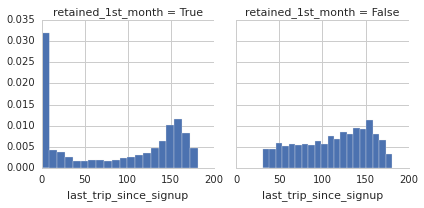

In [74]:
g = sns.FacetGrid(users1, col='retained_1st_month')
g = g.map(plt.hist, 'last_trip_since_signup', bins=20, normed=True)

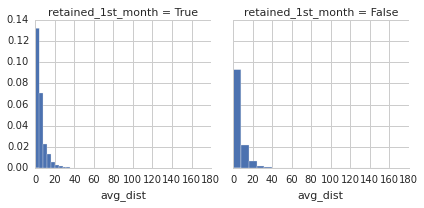

In [75]:
g = sns.FacetGrid(users1, col='retained_1st_month')
g = g.map(plt.hist, 'avg_dist', bins=20, normed=True)

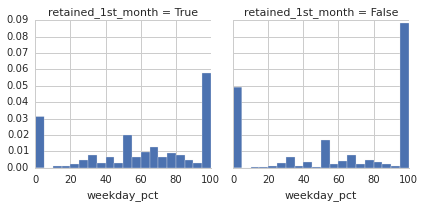

In [76]:
g = sns.FacetGrid(users1, col='retained_1st_month')
g = g.map(plt.hist, 'weekday_pct', bins=20, normed=True)

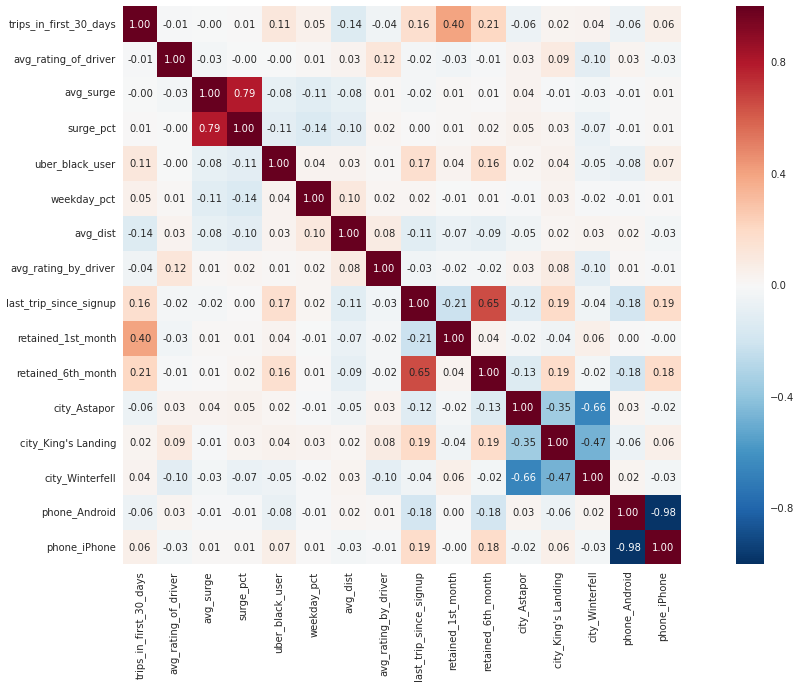

In [104]:
# create a heat map to show covariance of all variables 
plt.figure(figsize=(20, 10))
sns.heatmap(users1.corr(), cbar=True, annot=True, square=True, fmt='.2f', xticklabels=True, 
            yticklabels=True)

## Step 2: model training and evaluation
* Since there are some missing values at feature avg_rating_by_driver and avg_rating_of_driver. We can either only use data without any missing value in these two features to train the model. Or we can impute the missing values. Moedel evaluation can be used to see which strategy is better. 
* Use logistical regreesion and random forest and see which one is better

### Step 2.1: use data without any missing value to train a model

In [37]:
def split_train_test(data, features, label, imputed=False):
    """impute missing value in features if imputed is True. 
    after that, split data into traing and test data set"""
    if imputed: # need to impute missing value
        df = data[features + label]
        # save features into X and label into y
        X = df[features].values # numpy array
        y = df[label].ix[:, 0].values # 1d numpy array
        # split X, y into training and testing dataset
        X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=1234)        
        # in order to avoid data snooping, only use training data to fit Imputer
        imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
        X_train = imp.fit_transform(X_train)
        X_test = imp.transform(X_test)
    else: # remove any row with missing value
        df = (data[features + label]).dropna()
        # save features into X and label into y
        X = df[features].values # numpy array
        y = df[label].ix[:, 0].values # 1d numpy array
        # split X, y into training and testing dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)        
        
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X_train, X_test, y_train, y_test      

In [83]:
# decide what features are used in prediction
features = ['avg_rating_of_driver', 'avg_surge', 'surge_pct', 'uber_black_user', 'weekday_pct', 
            'avg_dist', 'avg_rating_by_driver', 'last_trip_since_signup', 'city_Astapor', 
            "city_King's Landing", 'city_Winterfell', 'phone_Android', 'phone_iPhone']
label = ['retained_1st_month']
X_train, X_test, y_train, y_test= split_train_test(data=users1, features=features, label=label, imputed=False)

(31308, 12) (10436, 12) (31308,) (10436,)


In [101]:
# logistic regression
def train_lr(X_train, X_test, y_train, y_test, parameters, features):
    '''use logistic regression as bench mark'''
    print('size of features in training: {}'.format(X_train.shape))
    pipe = Pipeline([('ss', StandardScaler()), 
                       ('lr', LogisticRegression(class_weight='auto', random_state=7))])
    clf = GridSearchCV(estimator=pipe, param_grid=parameters, scoring='f1', n_jobs=-1, cv=10)
    clf.fit(X_train, y_train)
    print('best parameters: {}'.format(clf.best_params_))
    
    # evaluate the peformance of estimator on testing data
    y_pred = clf.predict(X_test)
    print('\nsize of features in testing: {}'.format(X_test.shape))
    print('confusion matrix:')
    print(confusion_matrix(y_test, y_pred, labels=[True, False]))
    print('accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
    print('f1_score: {}'.format(f1_score(y_test, y_pred, labels=[True, False], pos_label=True)))
    
    return()

In [102]:
parameters={'lr__penalty': ['l1', 'l2'], 'lr__C': [0.01, 0.1, 1, 10, 100]}
lr = train_lr(X_train_std, X_test_std, y_train, y_test, parameters, features)

size of features in training: (31308, 12)
best parameters: {'lr__C': 0.1, 'lr__penalty': 'l2'}

size of features in testing: (10436, 12)
confusion matrix:
[[3893 3721]
 [1012 1810]]
accuracy score: 0.5464737447297815
f1_score: 0.6219346593178368


In [47]:
# random forest
def train_rfc(X_train, X_test, y_train, y_test, parameters, features):
    '''train random forest classifier and see the performance of model and feature importance, return the tuned model'''
    print('size of features in training: {}'.format(X_train.shape))
    estimator = RandomForestClassifier(class_weight='auto', random_state=7)
    clf = GridSearchCV(estimator=estimator, param_grid=parameters, scoring='f1', n_jobs=-1, cv=3)
    clf.fit(X_train, y_train)
    print('best parameters: {}'.format(clf.best_params_))
    # see feature importance
    feature_importance = pd.DataFrame({'feature':features, 'importance':clf.best_estimator_.feature_importances_})
    print('feature importance:')
    print(feature_importance.sort('importance',ascending=False))
    
    # evaluate the peformance of estimator on testing data
    y_pred = clf.predict(X_test)
    print('\nsize of features in testing: {}'.format(X_test.shape))
    print('confusion matrix:')
    print(confusion_matrix(y_test, y_pred, labels=[True, False]))
    print('accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
    print('f1_score: {}'.format(f1_score(y_test, y_pred, labels=[True, False], pos_label=True)))
    
    return(clf)

In [48]:
parameters={'n_estimators': [150], 'max_features': [3, 4, 5, 6, 7, 8, 9], 'criterion': ['gini', 'entropy']}
rfc = train_rfc(X_train, X_test, y_train, y_test, parameters, features)

size of features in training: (31308, 13)
best parameters: {'criterion': 'entropy', 'n_estimators': 150, 'max_features': 8}
feature importance:
                   feature  importance
7   last_trip_since_signup    0.365479
5                 avg_dist    0.189853
4              weekday_pct    0.127706
6     avg_rating_by_driver    0.086803
0     avg_rating_of_driver    0.058758
2                surge_pct    0.056763
1                avg_surge    0.037297
3          uber_black_user    0.019509
10         city_Winterfell    0.012913
12            phone_iPhone    0.011717
8             city_Astapor    0.011650
9      city_King's Landing    0.010950
11           phone_Android    0.010603

size of features in testing: (10436, 13)
confusion matrix:
[[6870  744]
 [1244 1578]]
accuracy score: 0.8095055576849367
f1_score: 0.8736012207527976


### Step 2.1: impute data with any missing value and train a model

In [72]:
X_train_imp, X_test_imp, y_train_imp, y_test_imp = split_train_test(data=users1, features=features, label=label, imputed=True)

(37500, 13) (12500, 13) (37500,) (12500,)


In [73]:
parameters={'n_estimators': [150], 'max_features': [3, 4, 5, 6, 7, 8, 9], 'criterion': ['gini', 'entropy']}
rfc_imp = train_rfc(X_train_imp, X_test_imp, y_train_imp, y_test_imp, parameters, features)

size of features in training: (37500, 13)
best parameters: {'criterion': 'entropy', 'n_estimators': 150, 'max_features': 8}
feature importance:
                   feature  importance
7   last_trip_since_signup    0.391744
5                 avg_dist    0.178008
4              weekday_pct    0.130835
6     avg_rating_by_driver    0.088321
0     avg_rating_of_driver    0.056929
2                surge_pct    0.049505
1                avg_surge    0.032829
3          uber_black_user    0.017963
10         city_Winterfell    0.012343
12            phone_iPhone    0.011361
8             city_Astapor    0.010612
9      city_King's Landing    0.009827
11           phone_Android    0.009722

size of features in testing: (12500, 13)
confusion matrix:
[[7777  895]
 [1363 2465]]
accuracy score: 0.81936
f1_score: 0.8732315293060857


## 2. Briefly discuss how Uber might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice). 
* F1_score of logistic regression is only 0.62 while f1_score of random forest is 0.87. Random forest is much better than logistic regression, which implies that the binary classifcation is not roughly linearly separable.  
* Model's performance with imputed data is almost the same as the model using data without imputation
* Three features including last_trip_since_signup, avg_dist, weekday_pct are significantly important to the prediction. They are the best predictors for retention. 

## EXTRA CREDIT
## Build a predictive model to help Uber determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

* Build a model to predict if a user will be retained in the 6th month. (see the results as followings)
* The reasons to choose random forest: 
    * no need to feature scaling
    * good at handling categorical variables
    * easy for parallal computing
    * good at handling very high dimensional features and large number of training examples
* f1_score is only 0.53, which is very low while accuary score is 0.75. This is becuase of imbalanced data. 

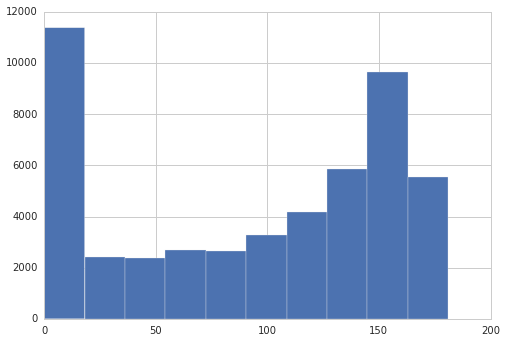

In [32]:
users1.last_trip_since_signup.hist()

In [33]:
users1.retained_6th_month.value_counts(normalize=True)

False    0.74572
True     0.25428
dtype: float64

In [51]:
# decide what features are used in prediction
features_6th_month = ['avg_rating_of_driver', 'avg_surge', 'surge_pct', 'uber_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'city_Astapor', "city_King's Landing",
       'city_Winterfell', 'phone_Android', 'phone_iPhone', 'trips_in_first_30_days']
label_6th_month = ['retained_6th_month']
X_train_6st_month, X_test_6st_month, y_train_6st_month, y_test_6th_month= split_train_test(data=users1, features=features_6th_month, label=label_6th_month, imputed=False)

(31308, 13) (10436, 13) (31308,) (10436,)


In [54]:
parameters={'n_estimators': [150], 'max_features': [3, 4, 5, 6, 7, 8, 9], 'criterion': ['gini', 'entropy']}
rfc_6th_month = train_rfc(X_train_6st_month, X_test_6st_month, y_train_6st_month, y_test_6th_month, parameters, features_6th_month)

size of features in training: (31308, 13)
best parameters: {'criterion': 'entropy', 'n_estimators': 150, 'max_features': 4}
feature importance:
                   feature  importance
5                 avg_dist    0.302121
4              weekday_pct    0.149855
6     avg_rating_by_driver    0.103760
12  trips_in_first_30_days    0.092139
0     avg_rating_of_driver    0.091667
2                surge_pct    0.087234
1                avg_surge    0.069577
8      city_King's Landing    0.027145
3          uber_black_user    0.022417
10           phone_Android    0.014807
11            phone_iPhone    0.014730
7             city_Astapor    0.013899
9          city_Winterfell    0.010648

size of features in testing: (10436, 13)
confusion matrix:
[[1485 1487]
 [1069 6395]]
accuracy score: 0.7550785741663473
f1_score: 0.5374592833876223
